<a href="https://colab.research.google.com/github/Edward-Gavin/ml-dl/blob/main/taitanic_lr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchkeras
!pip install torchmetrics

## 依赖导入

In [ ]:
import numpy as np
import pandas as pd
from torch import nn
import torch
from tqdm import tqdm
import os,sys,time
from torch.utils.data import Dataset,DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torchkeras.metrics import Accuracy
from copy import deepcopy
from torchmetrics.classification import BinaryAUROC

In [ ]:
print(os.getcwd())

/content


## 定义模型

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(15, 20),
            nn.ReLU(),
            nn.Linear(20,15),
            nn.ReLU(),
            nn.Linear(15,20),
            nn.ReLU(),
            nn.Linear(20,15),
            nn.ReLU(),
            nn.Linear(15, 1)
        )
        self.metrics = nn.ModuleList([BinaryAUROC()])

    def forward(self, x):
        return self.model(x)

    def metric_update(self, predictions, labels):
        self.metrics[0].update(predictions, labels)

    def metric_fn(self):
        metrics_outs = [met.compute().item() for met in self.metrics]
        [met.reset() for met in self.metrics]
        return metrics_outs

## 加载数据

In [ ]:
train_d = pd.read_csv("/content/sample_data/taitanic/train.csv")
predict_d = pd.read_csv("/content/sample_data/taitanic/test.csv")

train_data = train_d.head(int(891*0.8))
test_data = train_d.tail(int(891*0.2))

train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
707,708,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S
708,709,1,1,"Cleaver, Miss. Alice",female,22.0,0,0,113781,151.5500,NaN,S
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C


In [ ]:
test_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
713,714,0,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S
714,715,0,2,"Greenberg, Mr. Samuel",male,52.0,0,0,250647,13.0000,NaN,S
715,716,0,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.6500,F G73,S
716,717,1,1,"Endres, Miss. Caroline Louise",female,38.0,0,0,PC 17757,227.5250,C45,C
717,718,1,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 查看数据

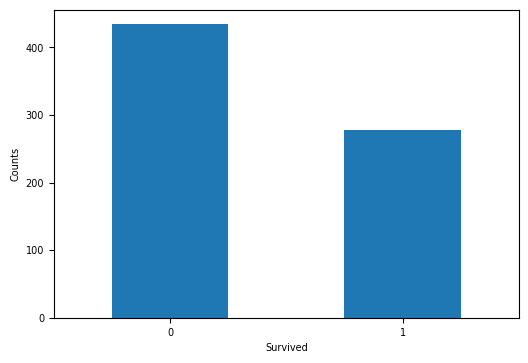

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = train_data['Survived'].value_counts().plot(kind = 'bar', figsize = (6,4),fontsize=7,rot = 0)
ax.set_ylabel('Counts',fontsize = 7)
ax.set_xlabel('Survived',fontsize = 7)
plt.show()

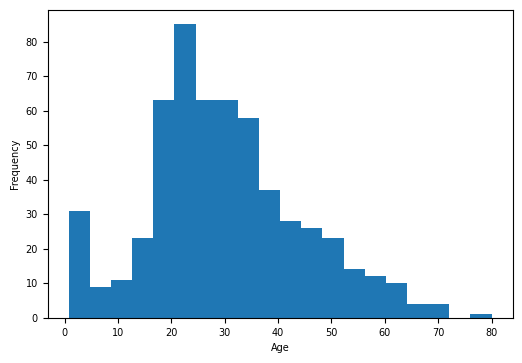

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='png'
age = train_data['Age'].plot(kind='hist', bins=20, figsize=(6,4), fontsize=7, rot=0)
age.set_ylabel('Frequency', fontsize=7)
age.set_xlabel('Age', fontsize=7)
plt.show()

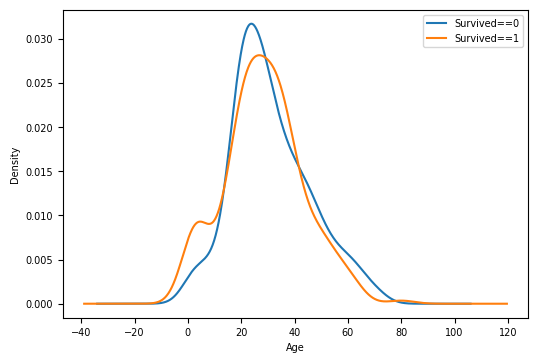

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = train_data.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (6,4),fontsize=7)
train_data.query('Survived == 1')['Age'].plot(kind = 'density', figsize = (6,4),fontsize=7)
ax.legend(['Survived==0','Survived==1'],fontsize = 7)
ax.set_ylabel('Density',fontsize = 7)
ax.set_xlabel('Age',fontsize = 7)
plt.show()

## 数据预处理

In [ ]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass']).astype(float)
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex']).astype(float)
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype(float)

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype(float)

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True).astype(float)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

In [ ]:
x_train = preprocessing(train_data).values
y_train = train_data[['Survived']].values
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()), shuffle=True, batch_size=36)

x_test = preprocessing(test_data).values
y_test = test_data[['Survived']].values
dl_test = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()), shuffle=False, batch_size=9)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(712, 15)
(178, 15)


In [ ]:
print(dl_train.batch_size)
print(dl_test.batch_size)

36
9


## 训练和测试

In [ ]:
# 模型定义
model = Net()
loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(model.parameters(),lr = 0.005)

# metrics


history = {}

epochs = 20


for i in range(epochs):
    # 训练
    model.train()

    train_total_loss = 0
    train_step = 0
    train_auc = 0

    loop = tqdm(enumerate(dl_train), total =len(dl_train),file = sys.stdout)

    print("第{}轮训练开始".format(i + 1))
    for index, data in loop:
        features, labels = data
        preds = model(features)

        model.metric_update(preds, labels)
        metrics_outs = model.metric_fn()

        train_auc += metrics_outs[0]


        # metrics_str = ' '.join(["Metric%d : %.3f" % (i, met) for i, met in enumerate(metrics_outs)])
        # print('=========================Training Epoch: %d %s ======================' % (train_step, metrics_str))

        loss = loss_fn(preds, labels)

        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_step += 1
        train_total_loss += loss.item()

        if train_step % 20 == 0:
            print("训练次数:{}, train total loss: {}, auc: {}".format(train_step, train_total_loss, train_auc / 20))
            train_auc = 0


    # 测试
    model.eval()

    test_total_loss = 0
    test_step = 0
    test_auc = 0
    loop = tqdm(enumerate(dl_test), total =len(dl_test),file = sys.stdout)
    print("第{}轮测试开始".format(i+1))

    with torch.no_grad():
        for i, batch in loop:
            features, labels = batch
            #forward
            preds = model(features)

            model.metric_update(preds, labels)
            metrics_outs = model.metric_fn()

            test_auc += metrics_outs[0]

            # metrics_str = ' '.join(["Metric%d : %.3f" % (i, met) for i, met in enumerate(metrics_outs)])
            # print('=========================Training Epoch: %d %s ======================' % (test_step, metrics_str))

            loss = loss_fn(preds, labels)

            test_total_loss += loss.item()
            test_step += 1
            if test_step % 20 == 0:
                print("测试次数: {}, test total loss: {}, auc: {}".format(test_step, test_total_loss, test_auc/20))
                test_auc = 0


    print("========================================")

  0%|          | 0/20 [00:00<?, ?it/s]第1轮训练开始
训练次数:20, train total loss: 13.466855227947235, auc: 0.5834615007042885
  0%|          | 0/20 [00:00<?, ?it/s]第1轮测试开始
测试次数: 20, test total loss: 11.96565905213356, auc: 0.6959920436143875
  0%|          | 0/20 [00:00<?, ?it/s]第2轮训练开始
训练次数:20, train total loss: 12.676590204238892, auc: 0.6887055426836014
  0%|          | 0/20 [00:00<?, ?it/s]第2轮测试开始
测试次数: 20, test total loss: 11.069412380456924, auc: 0.8030753910541535
  0%|          | 0/20 [00:00<?, ?it/s]第3轮训练开始
训练次数:20, train total loss: 11.945414423942566, auc: 0.7604913204908371
  0%|          | 0/20 [00:00<?, ?it/s]第3轮测试开始
测试次数: 20, test total loss: 10.546060651540756, auc: 0.8576190367341041
  0%|          | 0/20 [00:00<?, ?it/s]第4轮训练开始
训练次数:20, train total loss: 11.427504062652588, auc: 0.7785829126834869
  0%|          | 0/20 [00:00<?, ?it/s]第4轮测试开始
测试次数: 20, test total loss: 9.600518196821213, auc: 0.8561904713511467
  0%|          | 0/20 [00:00<?, ?it/s]第5轮训练开始
训练次数:20, train total

## 评估模型

## 模型预测

In [ ]:
# 数据处理
pred_data = preprocessing(predict_d).values

# 预测
y_pred_probs = torch.sigmoid(model(torch.tensor(pred_data).float())).data
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))

In [ ]:
# 预测导出
predictions = y_pred.t().numpy()[0]
predictions = pd.Series(predictions, dtype=np.int64)
output = pd.DataFrame({'PassengerId': predict_d.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## 模型保存与加载

In [ ]:
# 查看模型参数
print(model.state_dict().keys())

# 1. 保存模型参数
torch.save(model.state_dict(), "./taitanic_lr_model.pt")

model_clone = Net()
model_clone.load_state_dict(torch.load("./taitanic_lr_model.pt", weights_only=True))
a = torch.sigmoid(model_clone.forward(torch.tensor(x_test[0:10]).float())).data
print(a)

# 2. 保存完整模型
torch.save(model, "./taitanic_lr_model_all.pt")
model_clone_2 = torch.load("./taitanic_lr_model_all.pt", weights_only=False)
b = torch.sigmoid(model_clone_2.forward(torch.tensor(x_test[0:10]).float())).data
print(b)

odict_keys(['model.0.weight', 'model.0.bias', 'model.2.weight', 'model.2.bias', 'model.4.weight', 'model.4.bias'])
tensor([[0.0933],
        [0.1208],
        [0.1513],
        [0.9063],
        [0.7643],
        [0.1482],
        [0.0820],
        [0.7071],
        [0.1058],
        [0.1903]])
tensor([[0.0933],
        [0.1208],
        [0.1513],
        [0.9063],
        [0.7643],
        [0.1482],
        [0.0820],
        [0.7071],
        [0.1058],
        [0.1903]])
